Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_examples = 100
    score_name = "quality"
    clean_up = False

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_train_examples: int = m_examples
m_test_examples: int = m_examples
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# TODO: better estimate here
p_continue_est = np.mean( 
    (np.array(win_frequencies['win frequency'][range(1, win_frequencies.shape[0])]) + 1e-2)
 / (np.array(win_frequencies['win frequency'][range(0, win_frequencies.shape[0] - 1)]) + 1e-2)
)

p_continue_est

0.6047584541062802

In [19]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [20]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [21]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=p_continue_est,
)
fit_reading = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
    model_note='reading_model',
    clean_up=clean_up,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of reading on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of it

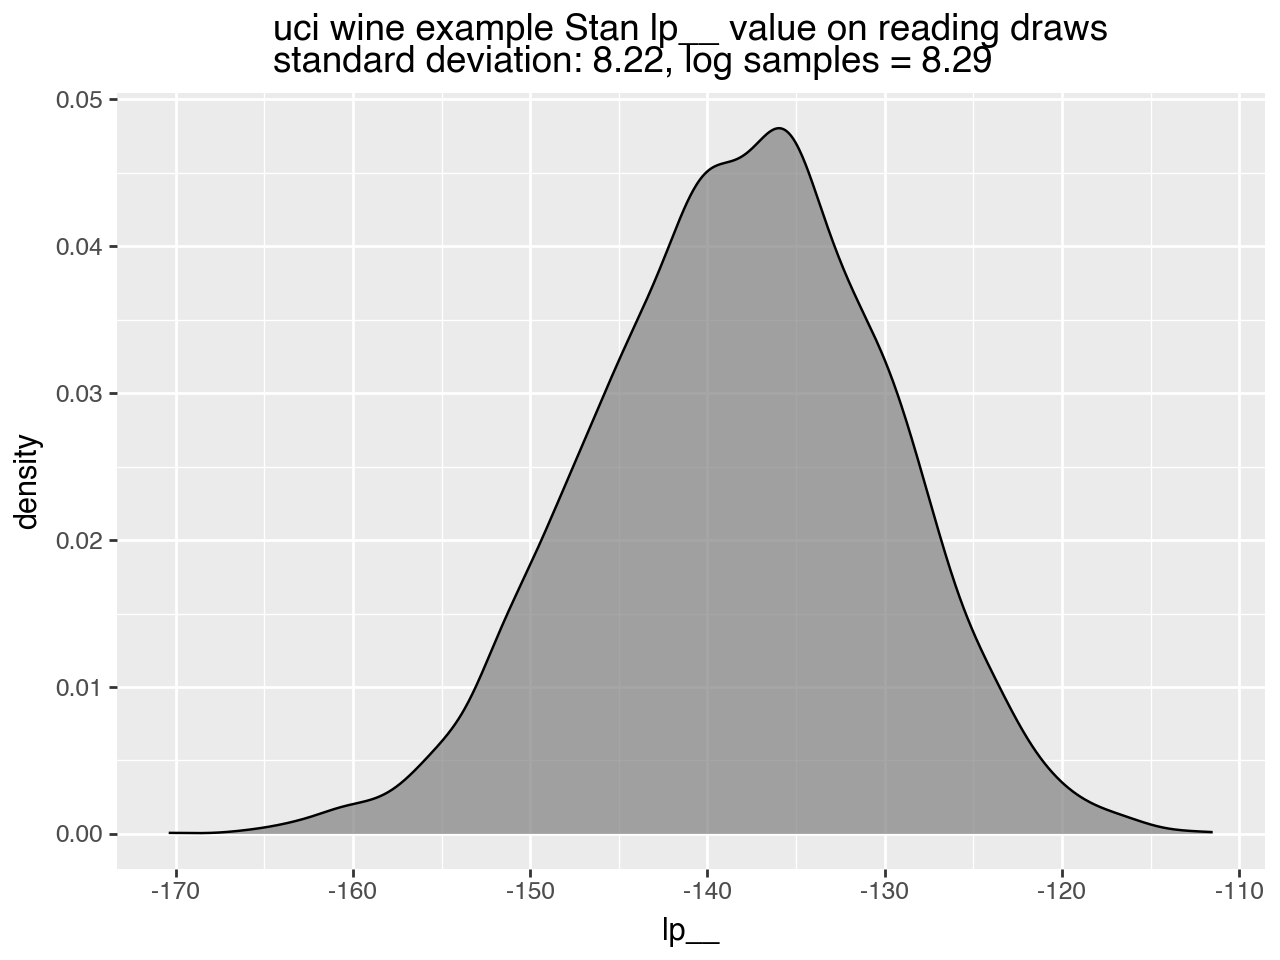

In [22]:
# get implied sample weights from chain
wt_frame = fit_reading.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on reading draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [23]:
beta_draws = fit_reading.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,-0.996658,-1.507880,-12.98020,-0.608189,-3.71406,0.203172,-0.272648,-10.041100,12.867300,8.624020,...,2.341220,0.983853,4.755300,-0.203985,0.010240,-2.097530,-2.040760,6.313070,4.69742,4.244730
1,-0.033136,2.291060,14.81800,2.305760,-1.81971,0.799456,-0.493210,5.579530,27.186900,-8.947680,...,15.076300,0.408694,0.647301,-0.247697,0.128298,7.506580,12.452900,5.684510,4.00482,13.931000
2,3.038240,-10.430000,-10.55870,-0.699992,2.42610,0.355745,-0.365564,-0.594480,-10.973400,-2.789640,...,-5.035450,0.919207,0.832430,0.066970,-0.130923,4.986190,-6.191870,10.133300,2.78891,-11.918700
3,-1.163400,-16.049200,-14.94790,-2.482320,13.70650,0.256049,-0.252895,4.349690,-0.754019,1.575550,...,-3.643010,0.992569,-3.838150,0.080173,-0.131913,3.332250,-0.110986,11.750600,3.05563,-0.325769
4,0.145669,17.478900,8.41195,0.091912,-11.91430,0.948836,-0.441236,0.339054,15.210700,-6.403540,...,7.288290,0.738752,4.968850,-0.222203,0.107145,-7.227750,-2.258660,-0.098845,4.87077,4.874890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.144539,-0.508599,-1.40753,-0.532915,-14.63310,0.311492,-0.092080,-9.487130,9.137710,3.905490,...,-10.344000,0.999327,2.942360,-0.250941,0.029519,5.018690,-2.570690,6.357100,5.51150,8.350720
3996,-0.237942,-3.597330,6.88948,-0.496650,-18.37840,0.392389,-0.331628,-3.394230,6.353790,-0.869876,...,-2.930890,1.223890,-0.380189,-0.128639,0.001857,-1.538160,-9.151720,8.691150,4.41448,10.820000
3997,-1.468550,-1.671820,-3.98324,-0.852059,15.10870,0.597134,-0.489436,6.346540,5.290310,1.244420,...,3.809380,0.596560,-2.888480,-0.138529,0.047955,-0.455390,0.673399,-10.054400,4.65765,-10.483600
3998,0.887536,-4.907020,-2.77060,-1.457940,-17.51970,0.161670,-0.340393,-1.659140,5.884840,-3.500090,...,0.438374,1.447200,3.539380,0.080366,-0.109452,-1.469370,1.528590,15.848300,2.83907,12.821300


In [24]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_reading_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
estimated_beta_reading_Stan

fixed acidity is red             0.270841
volatile acidity is red         -3.224784
citric acid is red               0.432479
residual sugar is red            0.039711
chlorides is red                -1.660661
free sulfur dioxide is red       0.612126
total sulfur dioxide is red     -0.483927
density is red                   1.034895
pH is red                        5.866079
sulphates is red                -3.121209
alcohol is red                   1.284229
fixed acidity is white          -1.683581
volatile acidity is white       -7.970326
citric acid is white             0.152431
residual sugar is white          0.799581
chlorides is white               0.552809
free sulfur dioxide is white    -0.083172
total sulfur dioxide is white   -0.014099
density is white                -1.054104
pH is white                      1.173620
sulphates is white               5.937864
alcohol is white                 3.309027
is_red                           0.889680
dtype: float64

In [25]:
estimated_beta_reading_Stan = list(estimated_beta_reading_Stan) + [0] * n_alternatives  # TODO: clean

picks


/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,row,position,pick probability estimate,was pick
0,0,0,0.3628,False
1,0,1,0.1656,False
2,0,2,0.1958,True
3,0,3,0.0861,False
4,0,4,0.1897,False
5,1,0,0.0956,False
6,1,1,0.3298,True
7,1,2,0.2949,False
8,1,3,0.1720,False
9,1,4,0.1077,False


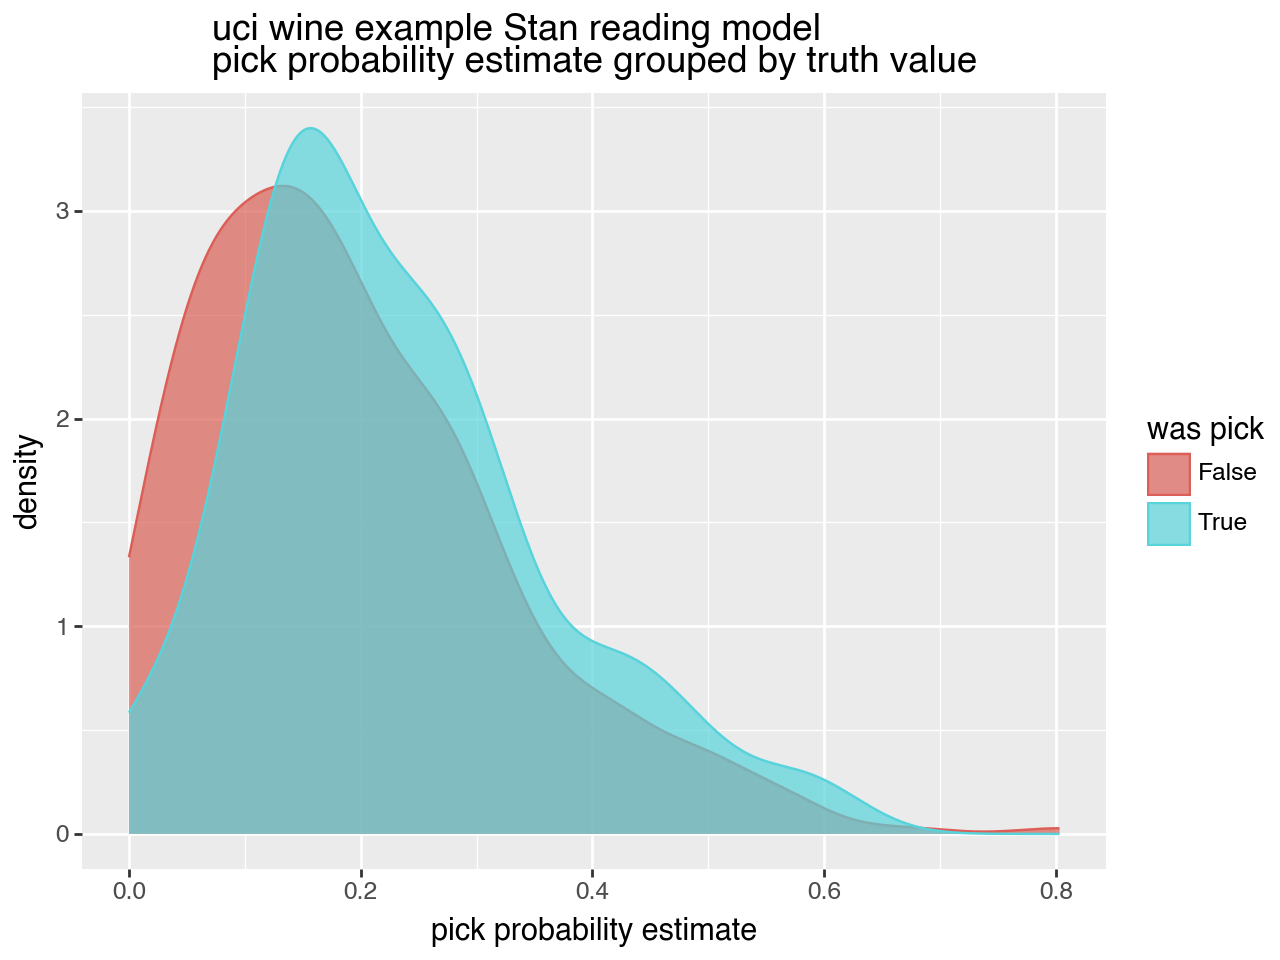

<Figure size 640x480 with 0 Axes>

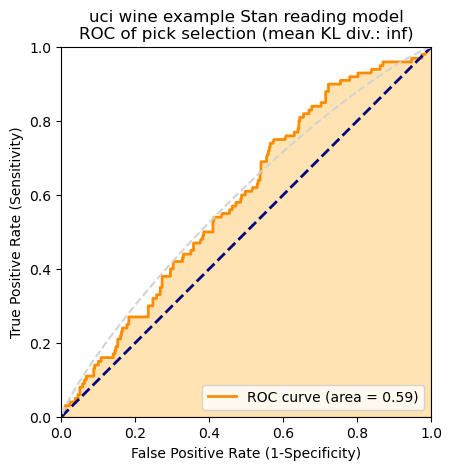

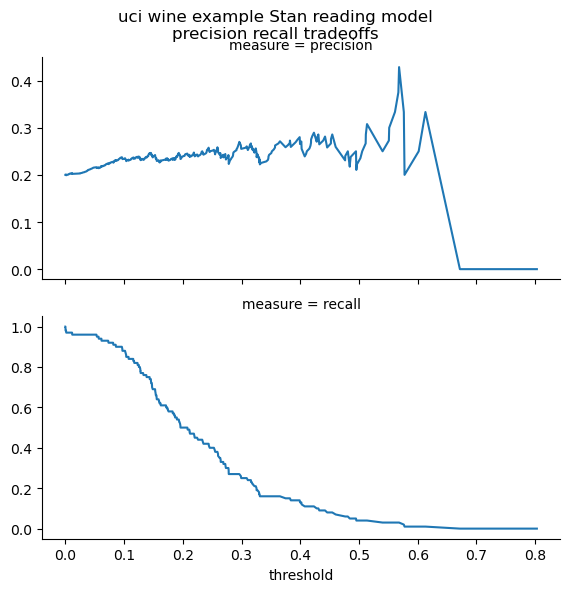

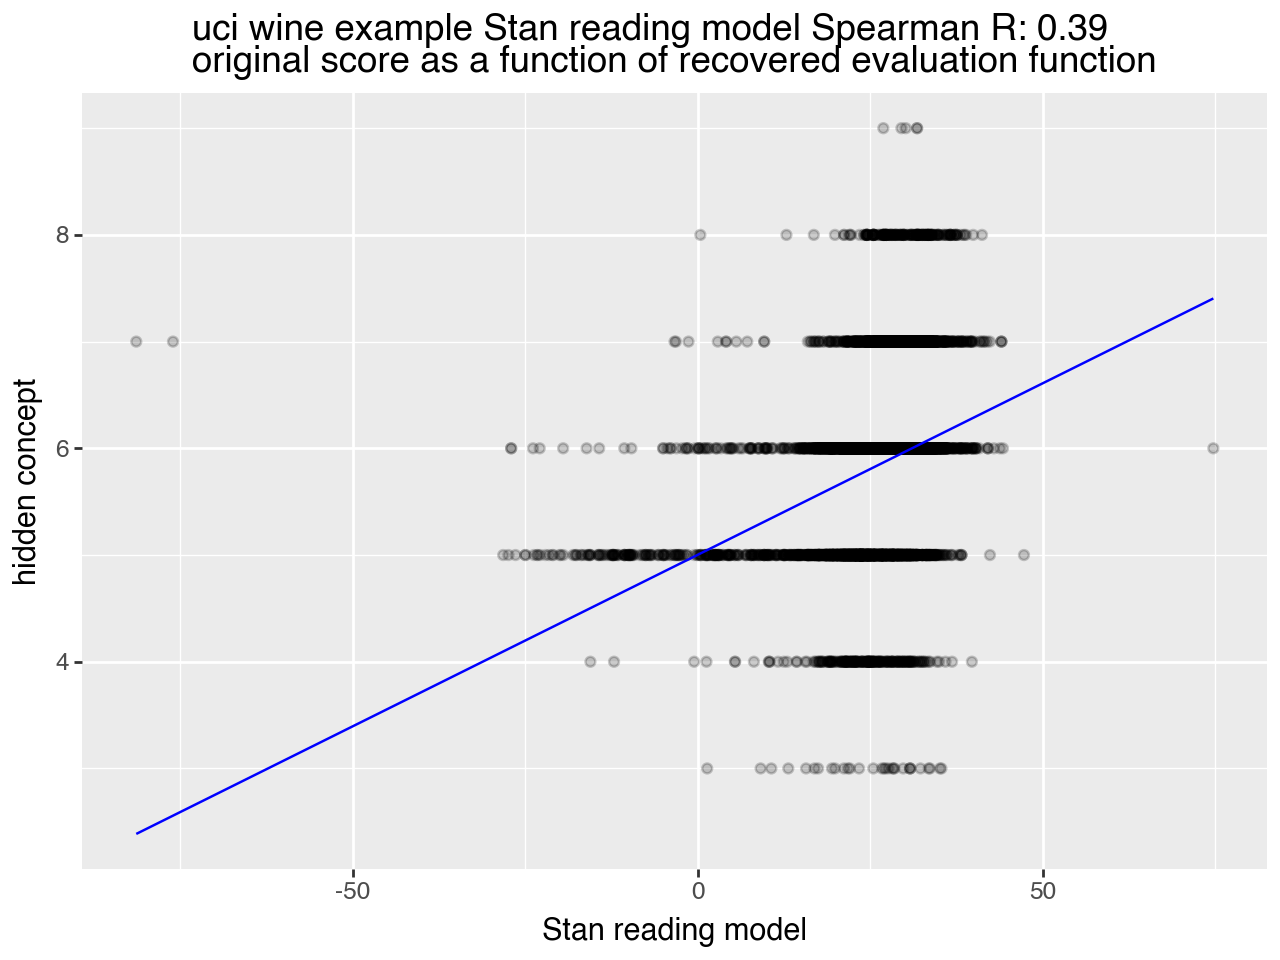

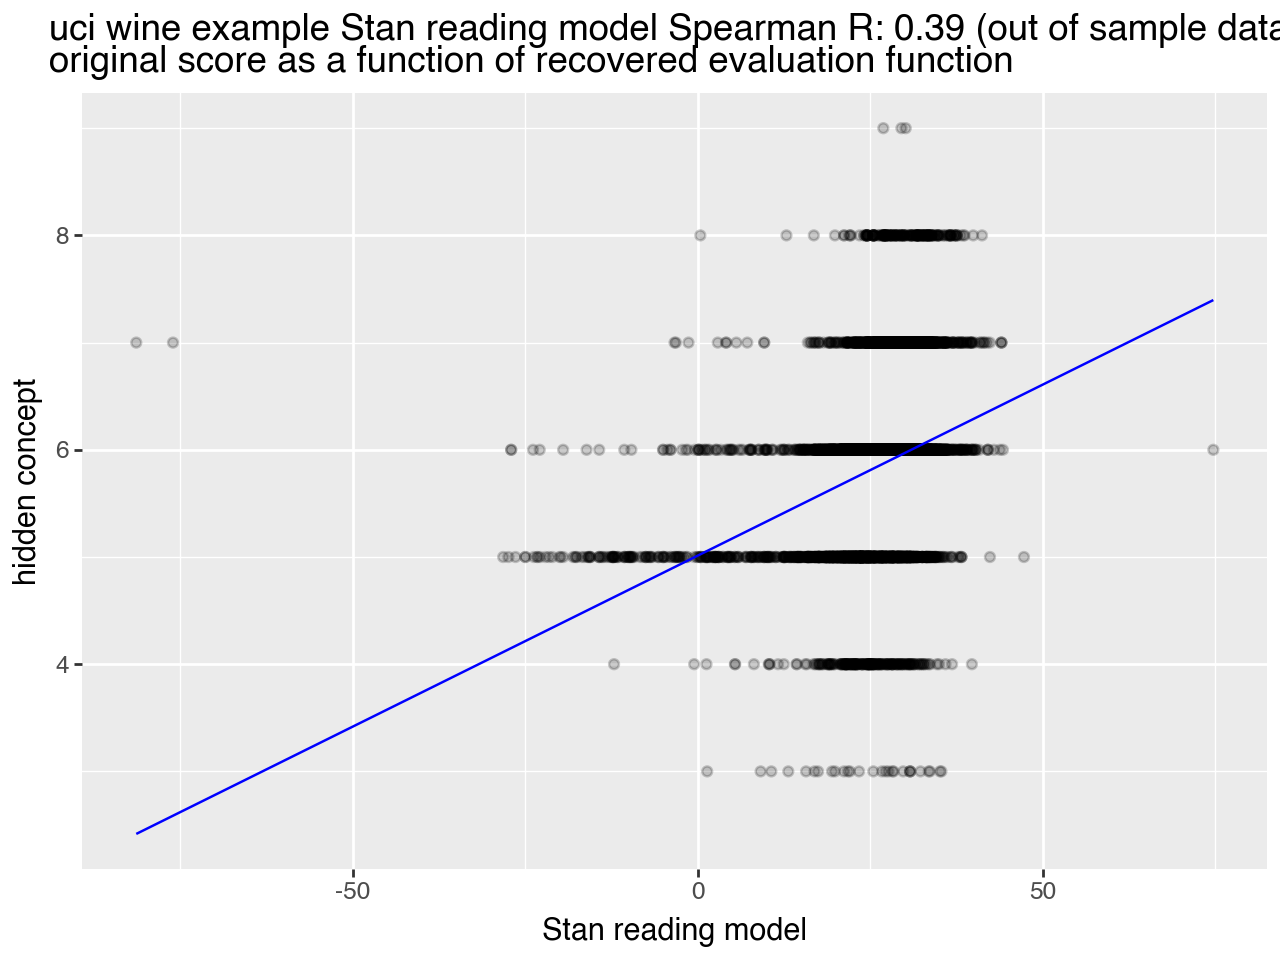

In [26]:
stat_pull_reading_Stan = plot_rank_performance(
    model=estimated_beta_reading_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_reading_Stan)

Try a Stan model with position choice modeled as utility.

In [27]:
observations_sorted_train = sort_observations_frame(observations_train)

In [28]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_panel_src)
data_str = format_Stan_data(
    observations_sorted=observations_sorted_train,
    features_frame=features_frame,
)
fit_utility_Stan = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
    model_note='utility_model',
    clean_up=clean_up,
)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [29]:
beta_draws_utility = fit_utility_Stan.draws_pd(vars=["beta"])
beta_draws_utility_display = beta_draws_utility.copy()
beta_draws_utility_display.columns = list(features_frame.columns) + [
    f'position_{sel_j}' for sel_j in range(n_alternatives)
]

beta_draws_utility_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_0,position_1,position_2,position_3,position_4
0,0.458380,0.021395,2.67896,-1.041280,9.88310,0.328277,-0.167765,-11.983000,-1.379520,-1.10020,...,1.40178,3.761050,1.955080,0.663940,-8.656090,12.734600,5.30135,3.879550,1.40831,3.793920
1,0.209362,-1.749720,-4.08671,-1.177550,6.47098,0.474265,-0.146714,-5.890720,0.705059,-5.63733,...,5.24483,5.130870,0.400643,1.421140,-6.325780,12.396400,4.05305,3.344680,-1.98867,-2.103080
2,0.088614,-6.728810,-3.36096,-0.469086,-13.34430,0.411244,-0.196157,11.677000,6.637530,-7.36447,...,-4.03489,-2.254590,12.613600,2.028080,1.871630,14.051900,8.10740,5.638060,2.22444,-0.192379
3,0.328871,-9.340600,-12.20590,-1.562750,8.87664,0.052683,-0.036417,-9.476140,5.045800,4.98682,...,-4.01417,3.974340,9.505770,2.133370,3.166050,15.307500,9.12908,6.590300,4.28791,-2.469520
4,-1.950790,0.010617,15.26620,-1.496240,-1.98353,0.531683,-0.369555,8.194790,2.201680,-22.40210,...,5.56160,-4.420720,-0.351671,1.285830,0.343837,4.309070,-2.08422,-2.345140,-8.40560,-11.097000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.020500,-1.321290,-3.82668,0.256441,-9.76784,0.260489,-0.244673,3.694710,16.695700,-9.28541,...,5.04809,-0.450252,-0.768375,2.998430,-13.293800,5.852310,1.40097,-1.009540,-7.35346,-10.264700
3996,0.452278,-4.529700,9.23135,-0.709651,-8.71710,0.588281,-0.265313,13.954800,3.863820,-6.01886,...,-4.38398,6.394940,2.322670,0.739288,-19.640000,11.089800,2.92584,0.302216,-4.46391,-6.214430
3997,-0.686792,-13.521600,-1.74960,-1.768410,-2.14877,0.146723,-0.192040,-12.506000,1.909220,-2.55234,...,4.35431,-5.125510,1.824250,3.799430,21.487100,21.948800,21.16170,14.936400,13.15630,8.567880
3998,0.578098,5.403390,5.04473,-2.956350,-2.58650,0.319004,-0.207612,-0.890821,8.806200,1.56647,...,-6.80696,3.801030,4.741640,3.380430,-19.071200,0.246884,-6.18252,-6.868200,-11.16850,-15.943800


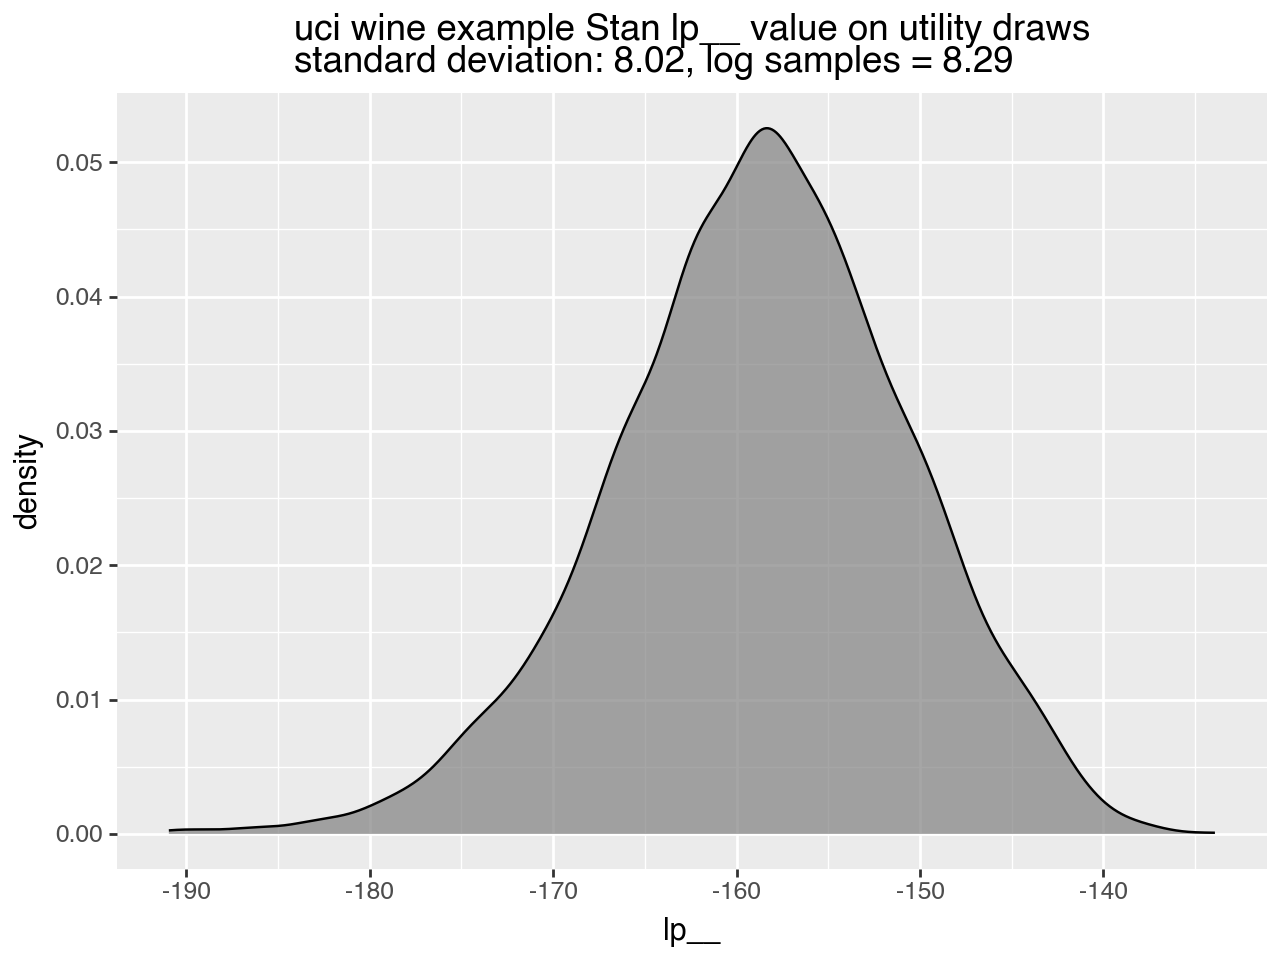

In [30]:
# get implied sample weights from chain
wt_frame_utility = fit_utility_Stan.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_utility["lp__"]))
    log_samples = np.log(wt_frame_utility.shape[0])
    (
        ggplot(
            data=wt_frame_utility,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on utility draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [31]:
estimated_beta_utility_Stan = beta_draws_utility_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame_utility["lp__"], 0.5), :
].mean()
estimated_beta_utility_Stan

fixed acidity is red             0.180403
volatile acidity is red         -4.267652
citric acid is red               3.413765
residual sugar is red           -0.969031
chlorides is red                -1.967542
free sulfur dioxide is red       0.266076
total sulfur dioxide is red     -0.176184
density is red                   1.324596
pH is red                        4.756431
sulphates is red                -5.272071
alcohol is red                   0.737162
fixed acidity is white          -1.368882
volatile acidity is white       -9.823919
citric acid is white            -2.788027
residual sugar is white          0.561407
chlorides is white               0.887928
free sulfur dioxide is white    -0.044290
total sulfur dioxide is white   -0.001431
density is white                -1.408677
pH is white                      0.647593
sulphates is white               5.530292
alcohol is white                 2.444402
is_red                           1.482133
position_0                       8

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6133,False
1,0,1,0.1756,False
2,0,2,0.1452,True
3,0,3,0.0339,False
4,0,4,0.0320,False
5,1,0,0.3265,False
6,1,1,0.3683,True
7,1,2,0.2115,False
8,1,3,0.0624,False
9,1,4,0.0313,False


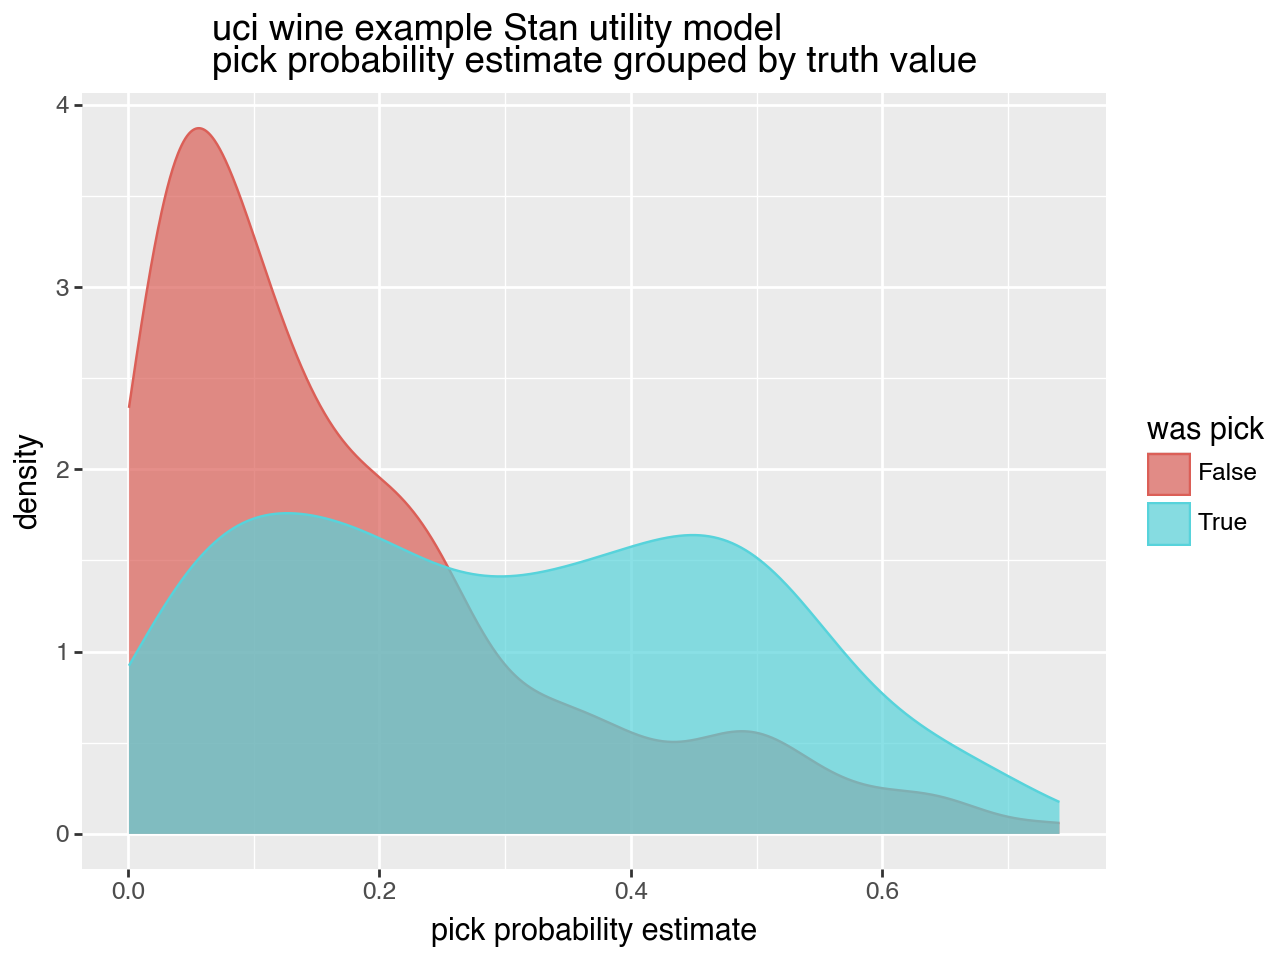

<Figure size 640x480 with 0 Axes>

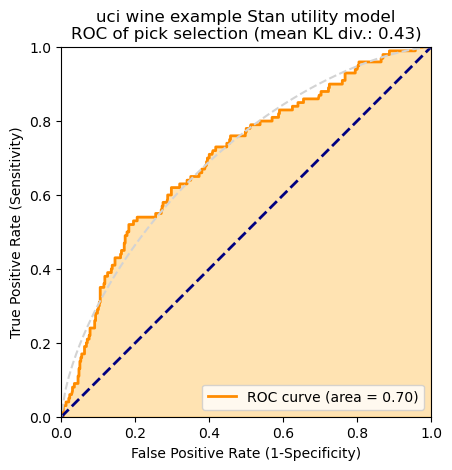

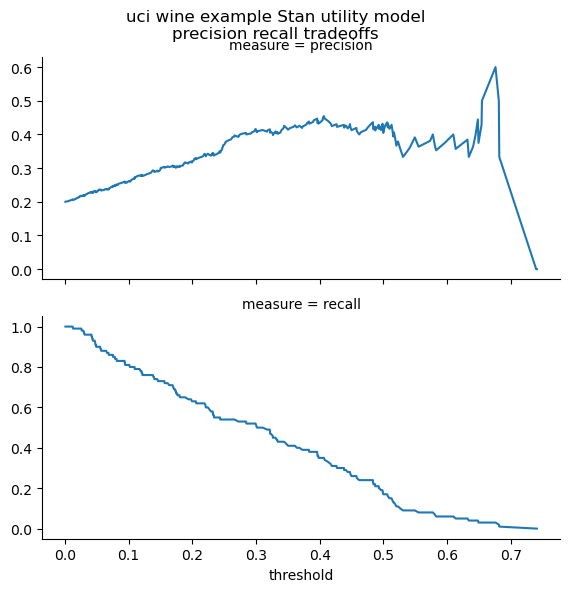

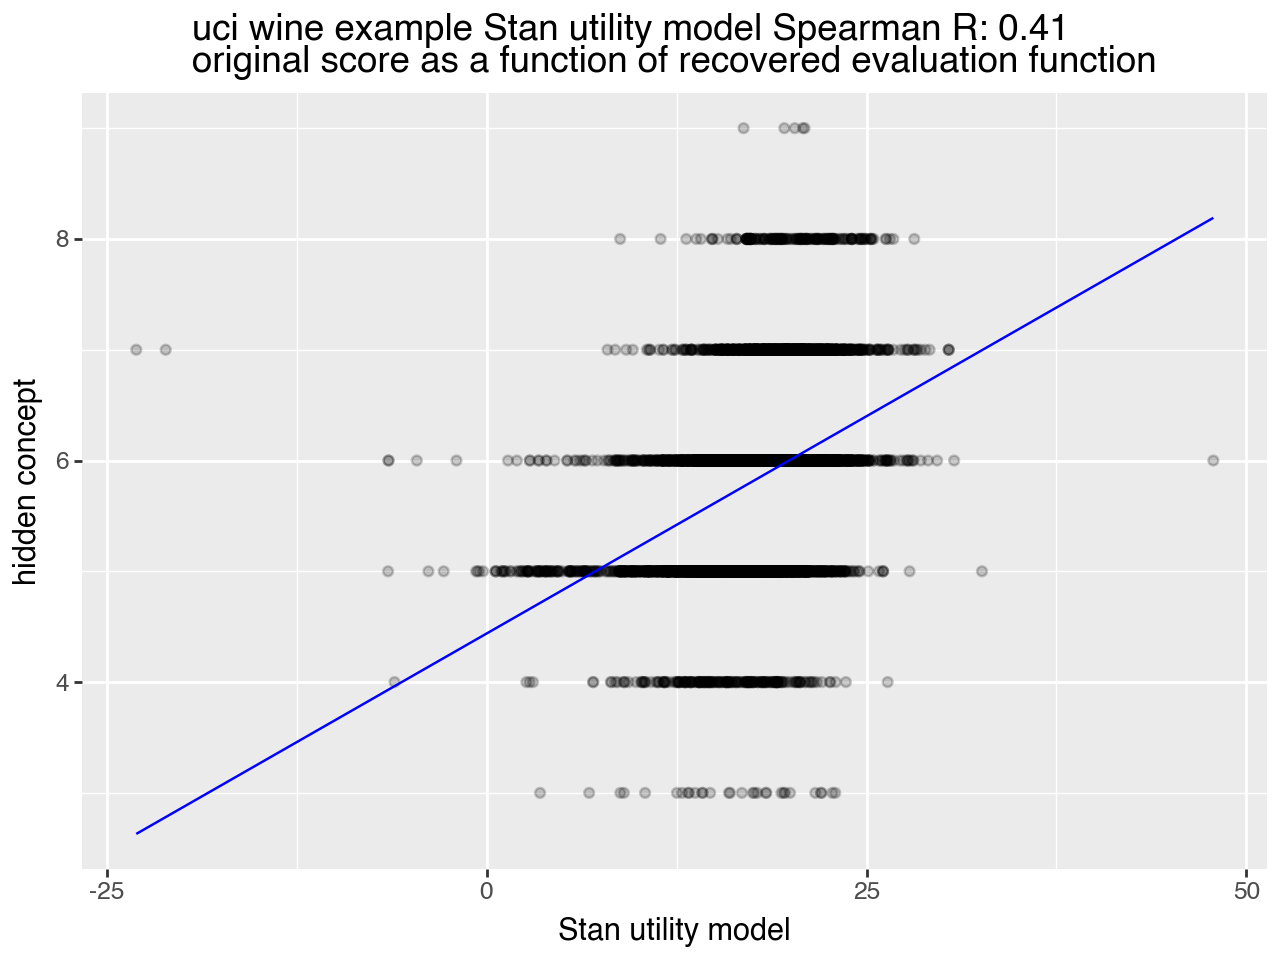

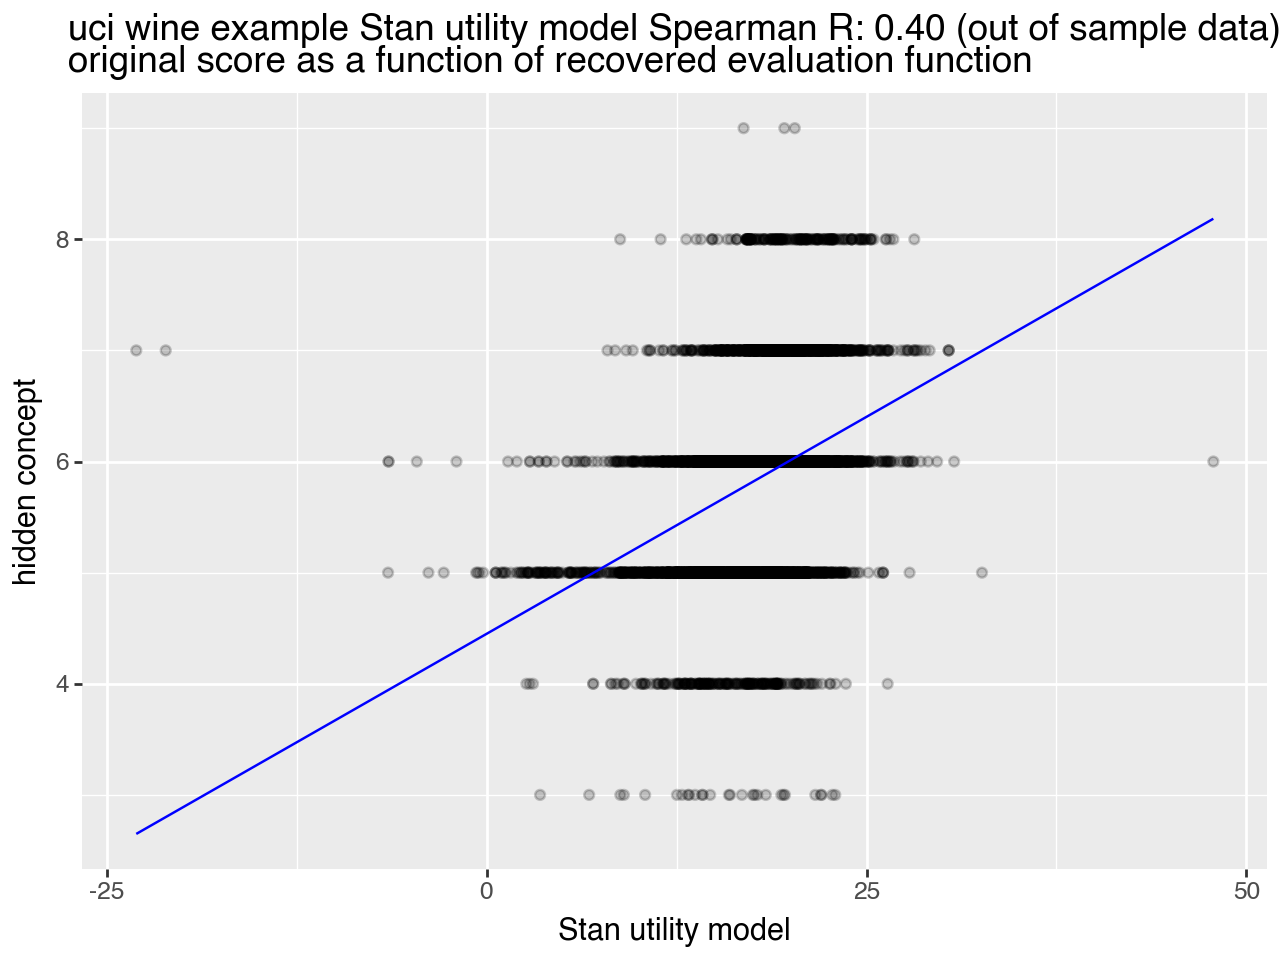

In [32]:
stat_pull_Stan = plot_rank_performance(
    model=estimated_beta_utility_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan utility model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_Stan)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [33]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [34]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [35]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2451,False
1,0,1,0.2146,False
2,0,2,0.2043,True
3,0,3,0.1709,False
4,0,4,0.1651,False
5,1,0,0.2227,False
6,1,1,0.2332,True
7,1,2,0.2033,False
8,1,3,0.1762,False
9,1,4,0.1646,False


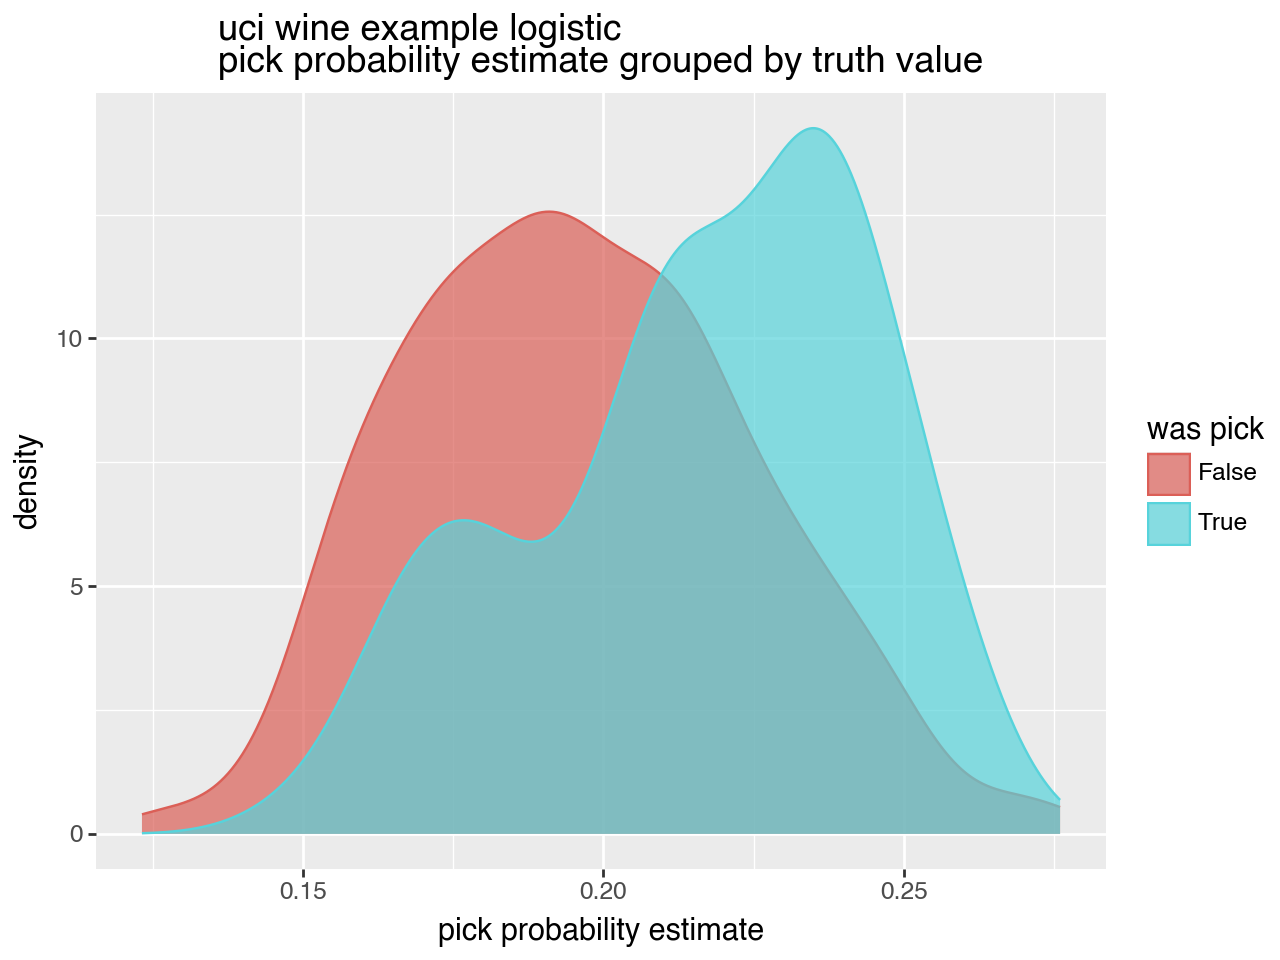

<Figure size 640x480 with 0 Axes>

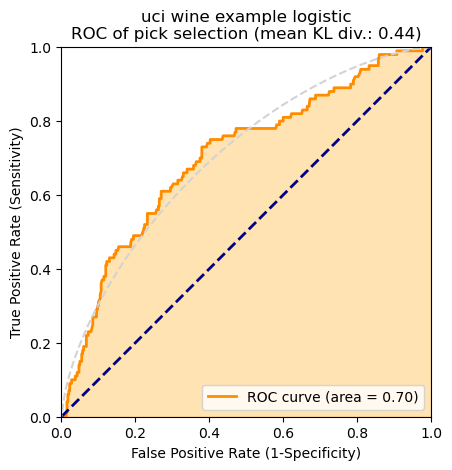

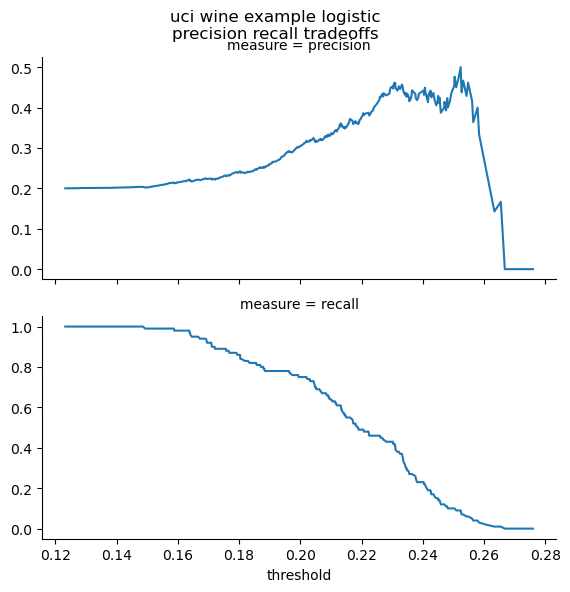

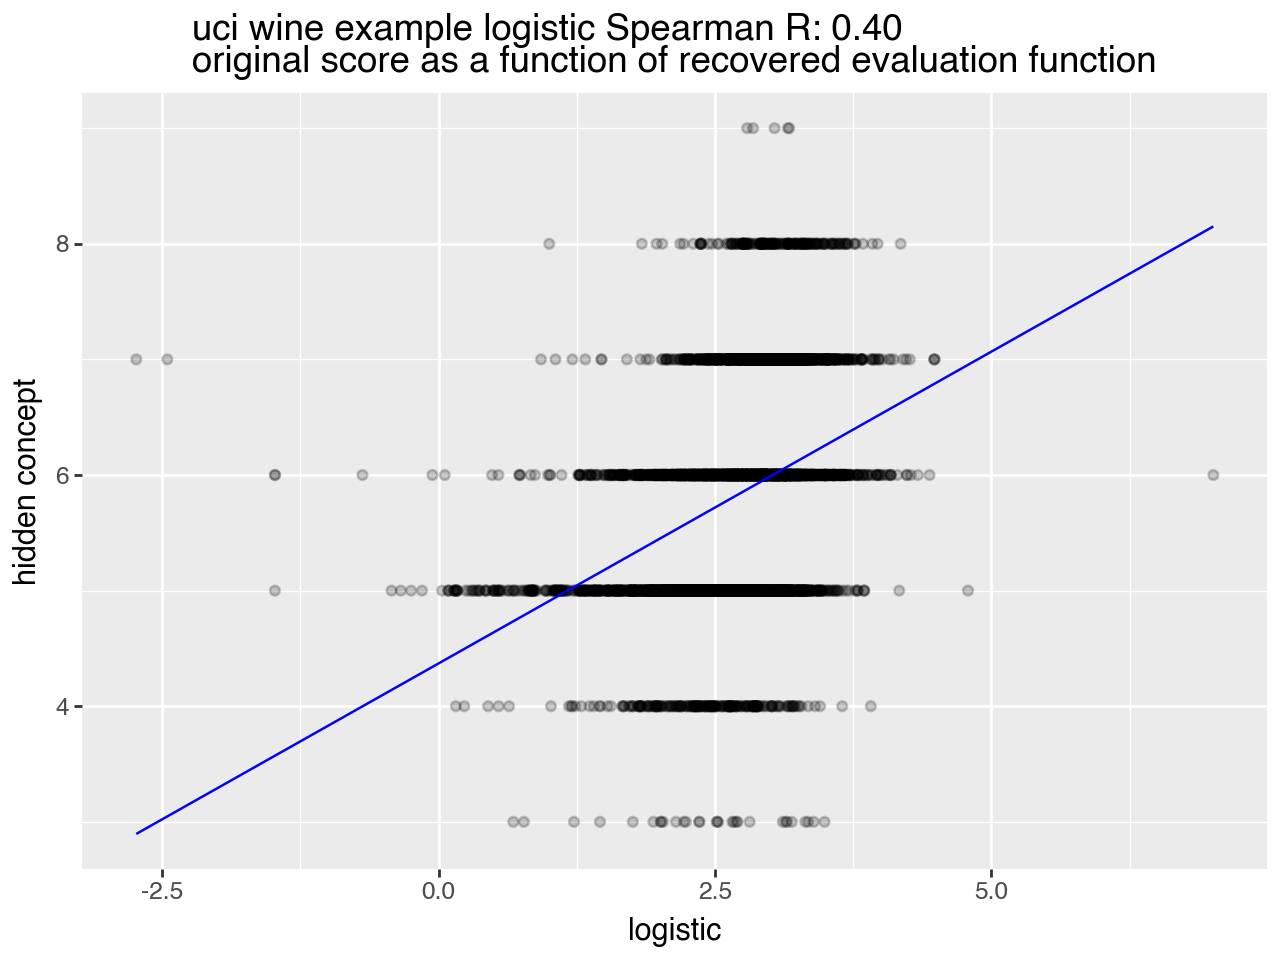

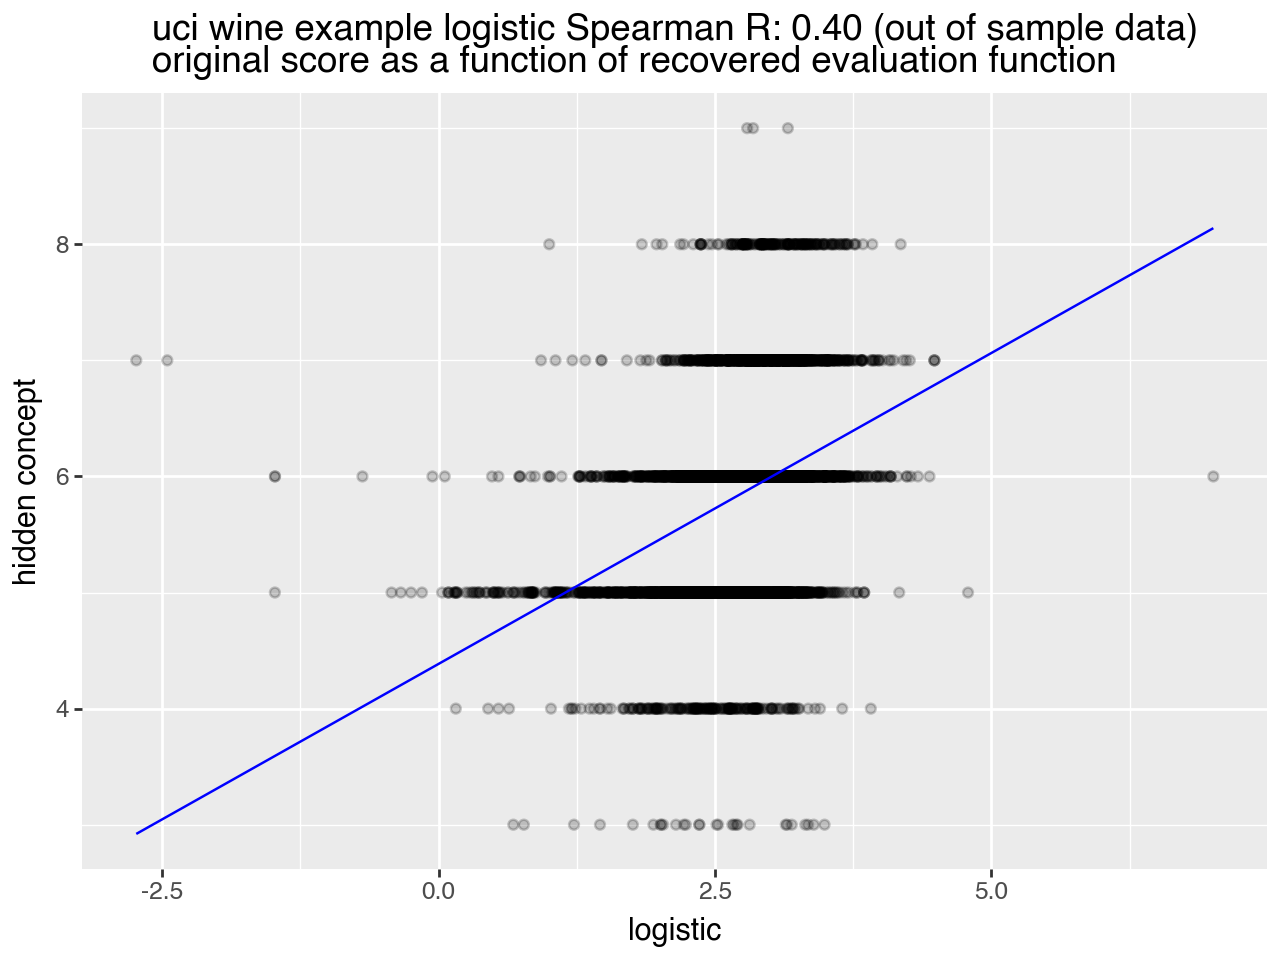

In [36]:
stat_pull_classifier = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_classifier)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2107,False
1,0,1,0.1969,False
2,0,2,0.2126,True
3,0,3,0.1951,False
4,0,4,0.1847,False
5,1,0,0.1908,False
6,1,1,0.2103,True
7,1,2,0.2092,False
8,1,3,0.1998,False
9,1,4,0.1899,False


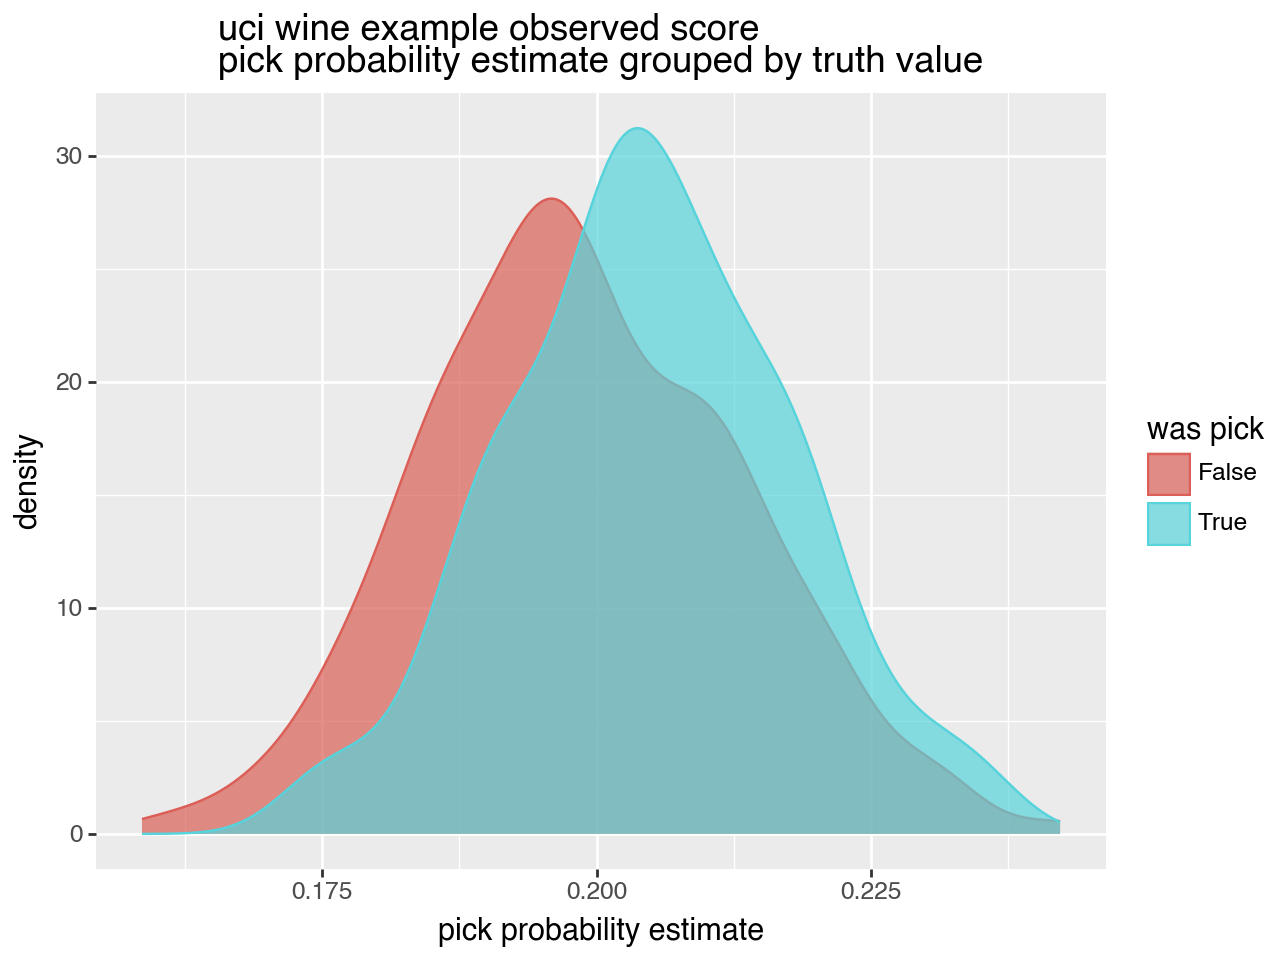

<Figure size 640x480 with 0 Axes>

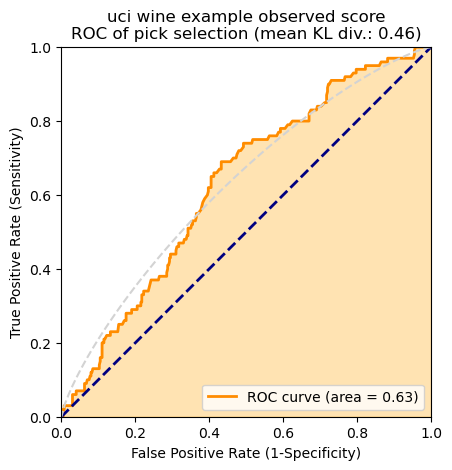

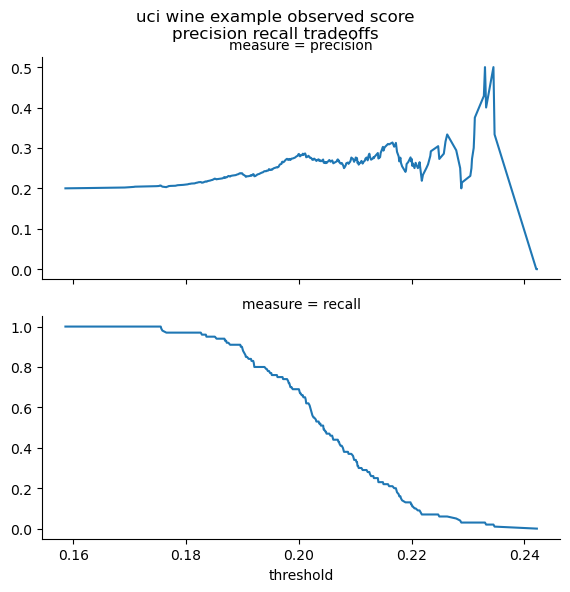

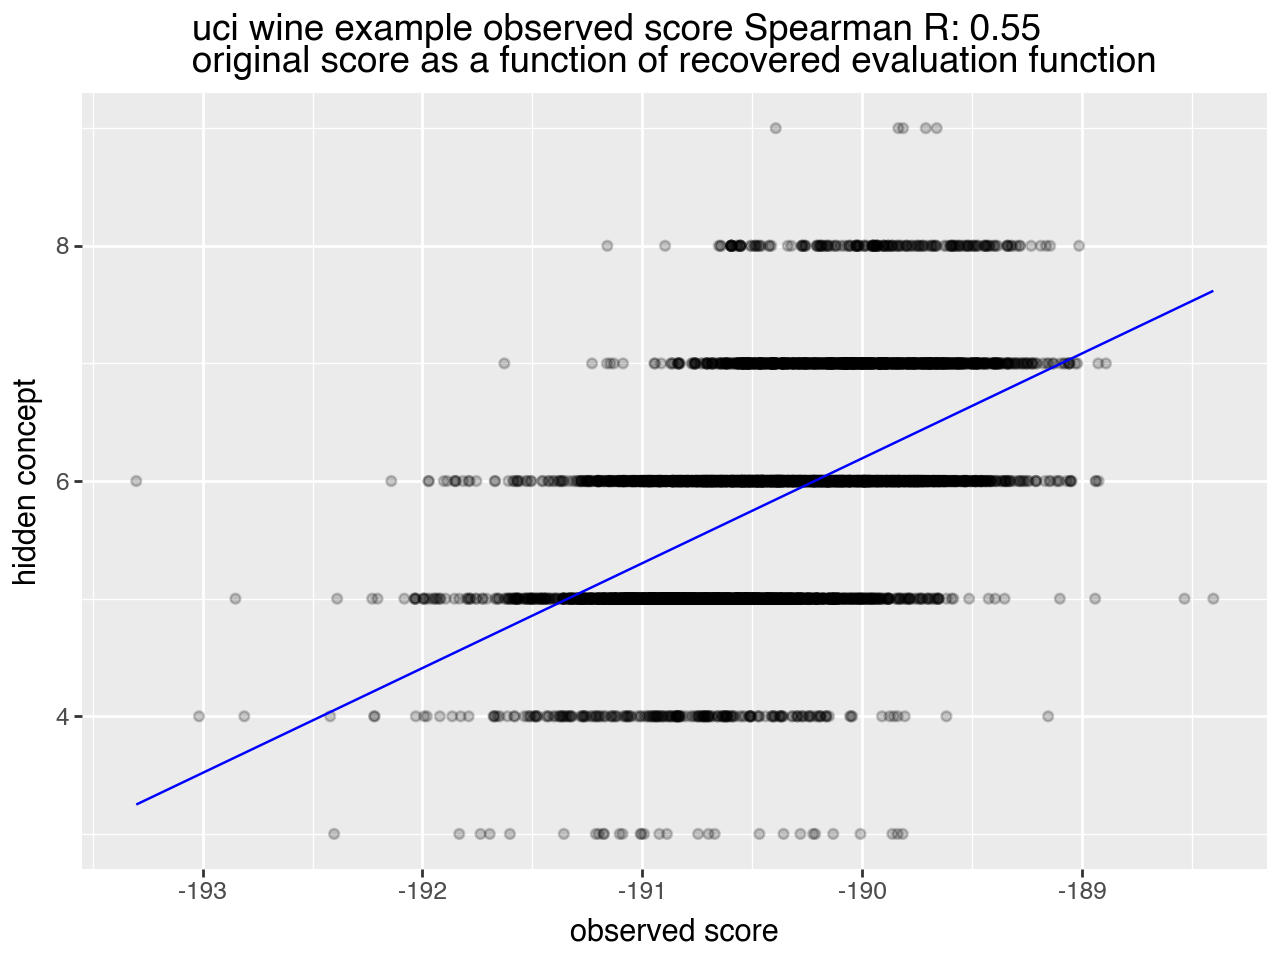

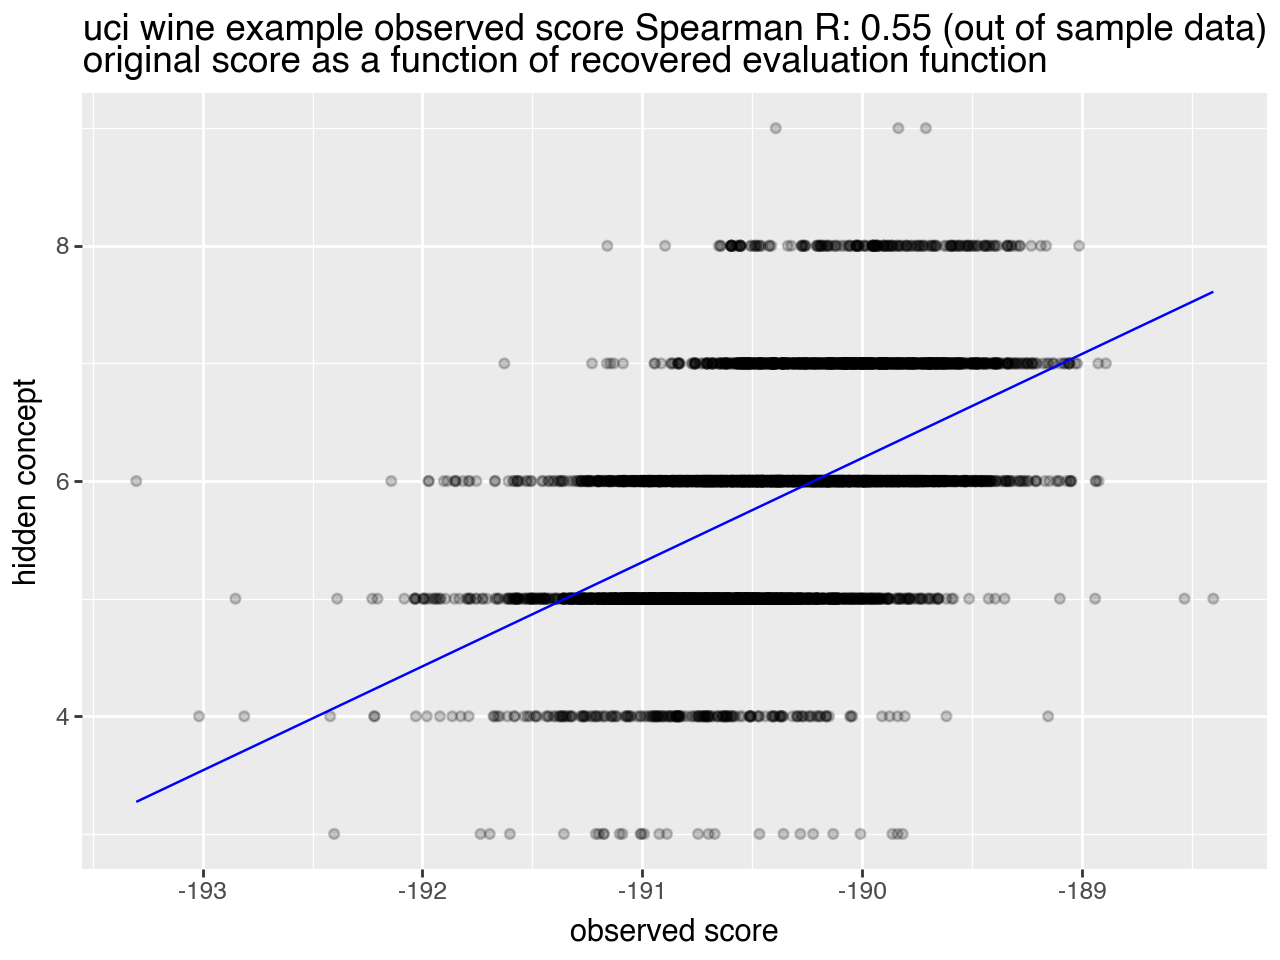

In [37]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [38]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [39]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [40]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.386840,0.385590,0.589738,inf,100,100,6497,6013
1,uci wine example,Stan utility model,0.405648,0.404625,0.702762,0.430913,100,100,6497,6013
2,uci wine example,logistic,0.401345,0.399807,0.702450,0.444034,100,100,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.627475,0.458029,100,100,6497,6013
